In [2]:
import cv2 
from PIL import Image 
import numpy as np 
import pandas as pd 
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split    

img_dir = 'train'
mask_dir = 'train/masks'
excel_file = 'train/classif.xlsx'
data_feature_file = 'data_features.csv'

# Load images
def load_images(img_dir, count):
    images = []
    for i in range(1, count + 1):
        img_path = os.path.join(img_dir, f"{i}.jpg")
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB format
            images.append(img)
        else:
            print(f"Image {img_path} not found.")
    return images

# Load masks
def load_masks(mask_dir, count):
    masks = []
    for i in range(1, count + 1):
        mask_path = os.path.join(mask_dir, f"binary_{i}.tif")
        if os.path.exists(mask_path):
            mask = Image.open(mask_path)
            mask = np.array(mask)
            # 检查掩码是否为灰度图像
            if mask.ndim == 3:
                mask = rgb2gray(mask)
            masks.append(mask)
            
        else:
            print(f"Mask {mask_path} not found.")
    return masks

# Load classification file
def load_classification(excel_file):
    if os.path.exists(excel_file):
        return pd.read_excel(excel_file)
    else:
        print(f"Excel file {excel_file} not found.")
        return None
    
# Load features
def load_features(data_feature_file):
    if os.path.exists(data_feature_file):
        return pd.read_csv(data_feature_file)
    else:
        print(f"Feature file {data_feature_file} not found.")
        return None    
    
images = load_images(img_dir, 250)
masks = load_masks(mask_dir, 250)
classif_df = load_classification(excel_file)   
features_df = load_features(data_feature_file)  

# 处理标签
def process_labels(df):
    bug_types = []
    species = []
    
    for _, row in df.iterrows():
        bugs = row['bug_type']
        species_info = row['species']
        
        # 处理x2
        if ' x2' in species_info:
            bugs = [bugs.replace(' x2','')] * 2
            species_info = [species_info.replace(' x2','')] * 2
        else:
            bugs = bugs.split(' & ')
            species_info = species_info.split(' & ')
        
        # 处理问号
        bugs = [bug.replace(' ?', '') for bug in bugs]
        species_info = [specie.replace(' ?', '') for specie in species_info]
        
        bug_types.append(bugs)
        species.append(species_info)
    
    df['bug_type'] = bug_types
    df['species'] = species
    return df

classif_df = process_labels(load_classification(excel_file))
# 使用MultiLabelBinarizer转换标签
mlb_bug_type = MultiLabelBinarizer()
mlb_species = MultiLabelBinarizer()
bug_type_encoded = mlb_bug_type.fit_transform(classif_df['bug_type'])
species_encoded = mlb_species.fit_transform(classif_df['species'])

# 转换为DataFrame
bug_type_df = pd.DataFrame(bug_type_encoded, columns=mlb_bug_type.classes_)
species_df = pd.DataFrame(species_encoded, columns=mlb_species.classes_)
#以及其他数据集
images = load_images(img_dir, 250)
masks = load_masks(mask_dir, 250)
features_df = load_features(data_feature_file)  



# 合并所有数据
all_data_df = pd.concat([classif_df.drop(columns=['bug_type', 'species']), bug_type_df, species_df, features_df], axis=1)


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import contingency_matrix

def ClassifyNN(X, trainX, trainY, K=1):
    C="-1"
    NN = np.zeros(K)
    for k in range(0,K):
        NN[k]=-1
    
    #searching for the K nearest neighhbors
    D=euclidean_distances([X],trainX)
    for k in range(0,K):
       mindist=np.infty
       for i in range(0,len(trainX)):
           
           if k==0:
               if(D[0][i]<mindist):
                   mindist=D[0][i]
                   NN[k]=i
           else:
                if(D[0][i]<mindist and not(i in NN) ):
                   mindist=D[0][i]
                   NN[k]=i                
    
    #classification
    classes= []
    for k in range(0,K):
        classes.append(trainY[NN[k].astype(int)])
    C=max(classes,key=classes.count)
        
    return C

In [24]:
def MyKNN(testX, trainX, trainY, K=1):
    
    if len(trainX)!=len(trainY) or len(trainX[0])!=len(testX[0]):
        return -1
    
    testY = []
    
    for i in range(0,len(testX)):
        testY.append(ClassifyNN(testX[i],trainX,trainY,K))
           
    
    return np.array(testY) 

In [29]:
classif_df = process_labels(load_classification(excel_file))
classif_df_string = classif_df
classif_df_string["bug_type"] = classif_df_string["bug_type"].apply(lambda x: ' '.join(x))
Y = classif_df_string["bug_type"].to_numpy()
X = features_df.to_numpy()

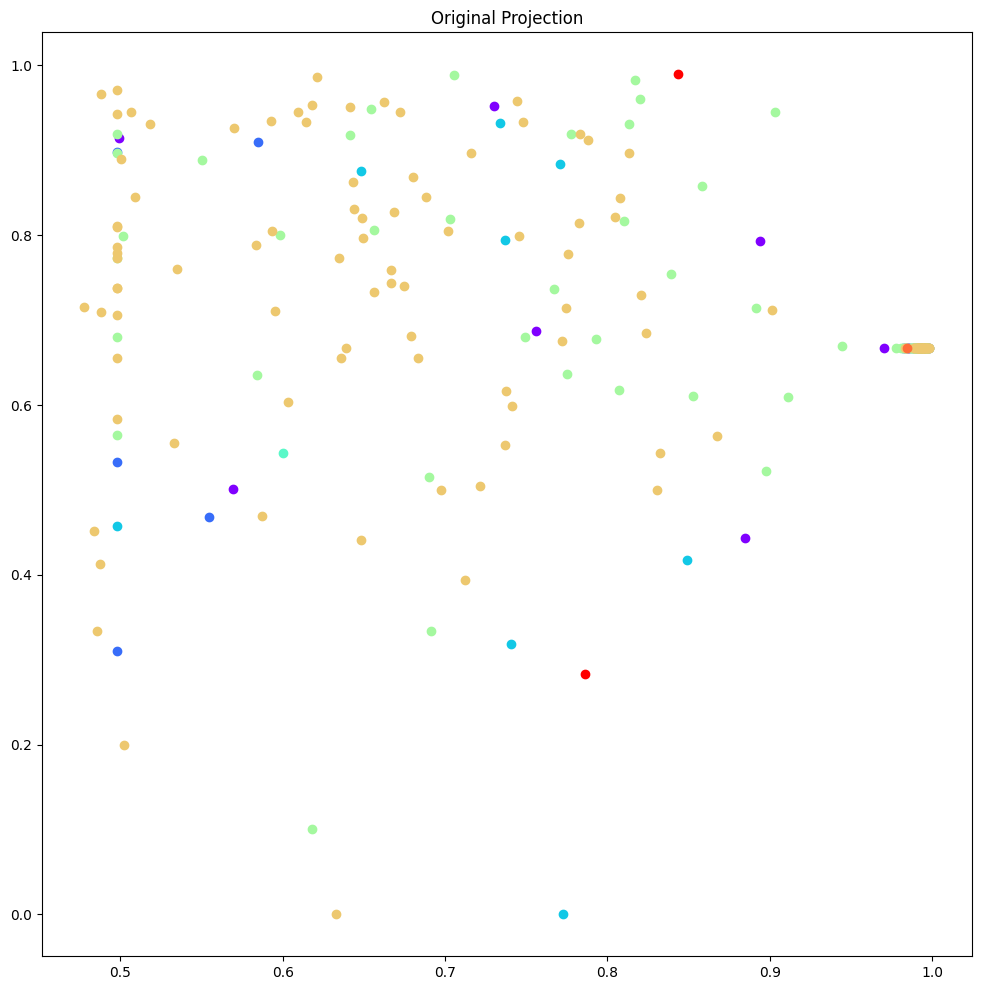

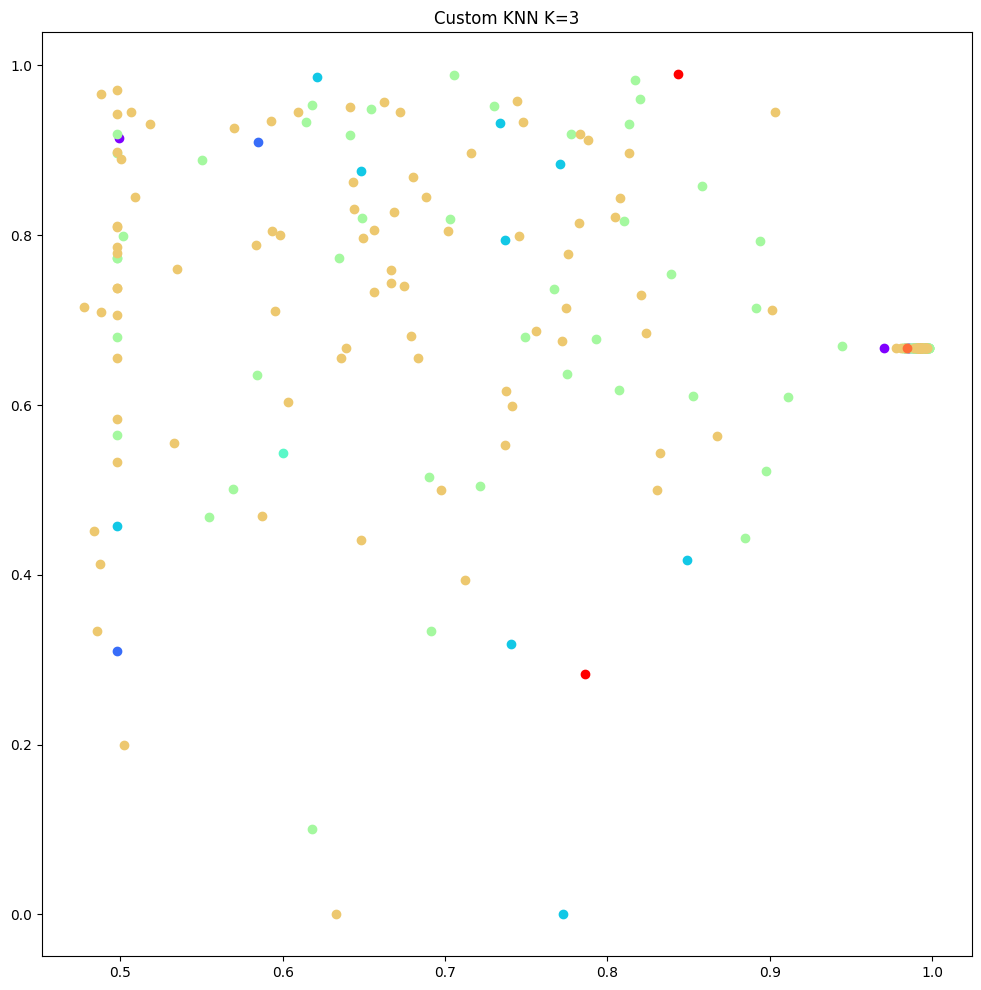

In [30]:
#what do this print ?
fig, ax = plt.subplots(figsize=(12,12))  
unique_labels = set(Y)
n_clusters = len(unique_labels)
colors = [plt.cm.rainbow(each) for each in np.linspace(0, 1, len(unique_labels))]
for klass, color in zip(unique_labels, colors):
    Xk=X[Y == klass]   
    ax.scatter(Xk[:,0], Xk[:,1], color=color)   
plt.title("Original Projection")
plt.show()


K=3 #change the K here
#explain these parameters
res=MyKNN(X,X,Y,K)

#what does this print ?
fig, ax = plt.subplots(figsize=(12,12))  
for klass, color in zip(unique_labels, colors):
    Xk=X[res == klass]   
    ax.scatter(Xk[:,0], Xk[:,1], color=color)   
plt.title("Custom KNN K=%d" % K )
plt.show()

随机森林和支持向量机部分

In [4]:
# 合并特征和标签数据
labels_df = bug_type_df  # 或者使用 species_df 作为标签

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=0.2, random_state=42)


# 训练随机森林分类器
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# 预测并计算准确度
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"随机森林分类准确度: {accuracy_rf}")


# 使用OneVsRest策略做svm
svm_classifier = OneVsRestClassifier(SVC(kernel='linear', random_state=42))
svm_classifier.fit(X_train, y_train)

# 预测并计算准确度
y_pred_svm = svm_classifier.predict(X_test)

# 计算准确度
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"支持向量机分类准确度 (One-vs-Rest): {accuracy_svm}")



训练集大小: 200, 测试集大小: 50
随机森林分类准确度: 0.5
支持向量机分类准确度 (One-vs-Rest): 0.42


In [8]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# 定义参数网格
param_grid_svm = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__gamma': [1, 0.1, 0.01, 0.001],
    'estimator__kernel': ['linear', 'rbf']
}

# 使用GridSearchCV进行参数搜索
grid_search_svm = GridSearchCV(estimator=OneVsRestClassifier(SVC(random_state=42)),
                               param_grid=param_grid_svm,
                               cv=3,
                               n_jobs=-1,
                               verbose=2)

# 训练模型
grid_search_svm.fit(X_train, y_train)

# 输出最佳参数
print(f"最佳参数 (SVM): {grid_search_svm.best_params_}")

# 使用最佳参数进行预测
best_svm = grid_search_svm.best_estimator_
y_pred_best_svm = best_svm.predict(X_test)

# 计算准确度
accuracy_best_svm = accuracy_score(y_test, y_pred_best_svm)
print(f"优化后的支持向量机分类准确度: {accuracy_best_svm}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits


python(51229) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51248) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51256) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51260) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51261) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51262) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51264) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/miniconda3/envs

[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=linear; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=linear; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=linear; total time=   0.1s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=linear; total time=   0.1s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0

/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.01, estimator__kernel=linear; total time=   0.2s
[CV] END estimator__C=1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.001, estimator__kernel=linear; total time=   0.2s
[CV] END estimator__C=1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s


/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=1, estimator__gamma=1, estimator__kernel=linear; total time=   0.5s
[CV] END estimator__C=1, estimator__gamma=0.1, estimator__kernel=linear; total time=   0.6s
[CV] END estimator__C=1, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1, estimator__gamma=0.01, estimator__kernel=linear; total time=   0.6s
[CV] END estimator__C=1, estimator__gamma=1, estimator__kernel=linear; total time=   0.7s
[CV] END estimator__C=1, estimator__gamma=0.1, estimator__kernel=linear; total time=   0.8s
[CV] END estimator__C=1, estimator__gamma=0.001, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1, estimator__gamma=0.001, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1, estimator__gamma=0.001, estimator__kernel=rbf; total time=   0.0s


/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=1, estimator__gamma=0.001, estimator__kernel=linear; total time=   0.5s
[CV] END estimator__C=1, estimator__gamma=1, estimator__kernel=linear; total time=   1.3s
[CV] END estimator__C=1, estimator__gamma=0.01, estimator__kernel=linear; total time=   0.8s
[CV] END estimator__C=10, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=1, estimator__gamma=0.01, estimator__kernel=linear; total time=   1.3s
[CV] END estimator__C=1, estimator__gamma=0.1, estimator__kernel=linear; total time=   1.4s
[CV] END estimator__C=1, estimator__gamma=0.001, estimator__kernel=linear; total time=   0.8s
[CV] END estimator__C=10, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s


/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=1, estimator__gamma=0.001, estimator__kernel=linear; total time=   1.3s


/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=10, estimator__gamma=0.1, estimator__kernel=linear; total time=   3.8s
[CV] END estimator__C=10, estimator__gamma=1, estimator__kernel=linear; total time=   4.0s
[CV] END estimator__C=10, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.0s


/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=10, estimator__gamma=1, estimator__kernel=linear; total time=   4.3s


/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=10, estimator__gamma=0.1, estimator__kernel=linear; total time=   4.4s
[CV] END estimator__C=10, estimator__gamma=1, estimator__kernel=linear; total time=   5.0s
[CV] END estimator__C=10, estimator__gamma=0.001, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10, estimator__gamma=0.001, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10, estimator__gamma=0.001, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=10, estimator__gamma=0.01, estimator__kernel=linear; total time=   4.0s
[CV] END estimator__C=10, estimator__gamma=0.1, estimator__kernel=linear; total time=   4.8s
[CV] END estimator__C=10, estimator__gamma=0.01, estimator__kernel=linear; total time=   5.1s
[CV] END estimator__C=100, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=100, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=100, estimator__gamma=1, estimator__kernel=rbf; total time=

/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=10, estimator__gamma=0.001, estimator__kernel=linear; total time=   3.8s
[CV] END estimator__C=10, estimator__gamma=0.01, estimator__kernel=linear; total time=   4.4s
[CV] END estimator__C=10, estimator__gamma=0.001, estimator__kernel=linear; total time=   4.9s
[CV] END estimator__C=100, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=100, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=100, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s


/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=10, estimator__gamma=0.001, estimator__kernel=linear; total time=   4.6s
[CV] END estimator__C=100, estimator__gamma=1, estimator__kernel=linear; total time=   9.6s


/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=100, estimator__gamma=1, estimator__kernel=linear; total time=  12.2s
[CV] END estimator__C=100, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=100, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=100, estimator__gamma=0.01, estimator__kernel=rbf; total time=   0.0s


/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=100, estimator__gamma=0.1, estimator__kernel=linear; total time=   9.7s


/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=100, estimator__gamma=0.1, estimator__kernel=linear; total time=  12.6s


/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=100, estimator__gamma=0.01, estimator__kernel=linear; total time=  12.4s
[CV] END estimator__C=100, estimator__gamma=0.001, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=100, estimator__gamma=0.001, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=100, estimator__gamma=0.001, estimator__kernel=rbf; total time=   0.0s


/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=100, estimator__gamma=1, estimator__kernel=linear; total time=  18.8s
[CV] END estimator__C=100, estimator__gamma=0.01, estimator__kernel=linear; total time=   9.4s
[CV] END estimator__C=100, estimator__gamma=0.1, estimator__kernel=linear; total time=  18.8s
[CV] END estimator__C=100, estimator__gamma=0.01, estimator__kernel=linear; total time=  17.5s


/opt/miniconda3/envs/tf_env/lib/python3.12/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(


[CV] END estimator__C=100, estimator__gamma=0.001, estimator__kernel=linear; total time=   7.6s
[CV] END estimator__C=100, estimator__gamma=0.001, estimator__kernel=linear; total time=  10.3s
[CV] END estimator__C=100, estimator__gamma=0.001, estimator__kernel=linear; total time=  15.1s
最佳参数 (SVM): {'estimator__C': 10, 'estimator__gamma': 0.001, 'estimator__kernel': 'rbf'}
优化后的支持向量机分类准确度: 0.56


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 转换数据为Tensor
X = torch.tensor(images).permute(0, 3, 1, 2).float() / 255.0  # 归一化到[0,1]
y = torch.tensor(bug_type_encoded).float()

# 创建数据集和数据加载器
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 初始化模型和优化器
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [ ]:
# 训练模型
num_epochs = 20
for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0
    for data in train_loader:
        inputs, _ = data
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader)}")

In [ ]:
# 提取编码器部分用于特征提取
encoded_data = []
labels = []
autoencoder.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, targets = data
        encoded = autoencoder.encoder(inputs)
        encoded = encoded.view(encoded.size(0), -1)  # 展平为二维
        encoded_data.append(encoded)
        labels.append(targets)

encoded_data = torch.cat(encoded_data)
labels = torch.cat(labels)

# 转换为numpy数组
encoded_data_np = encoded_data.numpy()
labels_np = labels.numpy()

# 训练分类器
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(encoded_data_np, labels_np)

# 预测和评估
y_pred_rf = rf_classifier.predict(encoded_data_np)
accuracy_rf = accuracy_score(labels_np, y_pred_rf)
print(f"Autoencoder + Random Forest - Accuracy: {accuracy_rf}")

In [9]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# 定义数据集类
class BeeDataset(Dataset):
    def __init__(self, img_dir, mask_dir, labels, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.labels = labels
        self.transform = transform
        self.image_ids = list(labels.index)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        mask_path = os.path.join(self.mask_dir, f"binary_{img_id}.tif")

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        label = self.labels.iloc[idx]
        return image, label

# 定义数据增强和预处理
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# 加载标签数据
labels_df = pd.read_excel('train/classif.xlsx')
labels_df['ID'] = labels_df.index + 1

# 创建数据集和数据加载器
train_dataset = BeeDataset(img_dir='train', mask_dir='train/masks', labels=labels_df, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = len(labels_df['bug_type'].unique())
model = SimpleCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# 评估模型
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"CNN Accuracy: {accuracy}")


TypeError: __call__() got an unexpected keyword argument 'image'